# Model Evaluation

## Import libraries

In [1]:
# Import libraries
import torch
import torchvision
import cv2
import glob
import xml.etree.ElementTree as ET
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image

In [2]:
# to save kernel from dying
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Model Loading and Evaluation

The code load a pretrained model and put in fine tuned weights and classes

In [3]:
# Specify the number of classes (including background)
num_classes = 3  # ('person', 'tag', and 'background') 3 classes

# Load the model without pretrained weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

# Specify the path where your model checkpoint is saved
model_path = r"C:\Users\ruyit\Desktop\Play (Python)\Object detection (person + tag = staff)\model.pth"

# Replace the box predictor to match the number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the fine-tuned weights
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval() # Set to evaluation mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

The following code visualize the predictions

In [4]:
# Move to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [5]:
# Image pre-processing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0).to(device), image  # Add batch dimension and return PIL image

To detect staff (person with tag), the following steps are taken:
* Identify the "tag" with highest score, draw the bounding box
* Find the "person" bounding box which surrounds that "tag", draw the bounding box
* Label the person with tag as "staff" and print the coordinate (midpoint of person bounding box)
* If tag is not identified, draw the person box with highest score <br>

**Note:** confidence threshold chosen for score is > 0.5

In [6]:
def predict_and_visualize(image_path, confidence_threshold=0.5):
    image_tensor, original_image = preprocess_image(image_path)
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']  # Get the labels for each prediction
    
    # Find the maximum score for "person" (class 1) and "tag" (class 2)
    person_mask = labels == 1  # Assuming class 1 is 'person'
    tag_mask = labels == 2  # Assuming class 2 is 'tag'
    
    person_boxes = boxes[person_mask]
    person_scores = scores[person_mask]
    
    tag_boxes = boxes[tag_mask]
    tag_scores = scores[tag_mask]
    
    # Initialize variables for maximum scores and boxes
    max_tag_box = None
    max_tag_score = 0
    
    # Find max tag box
    if len(tag_scores) > 0:
        max_tag_idx = tag_scores.argmax().item()
        max_tag_box = tag_boxes[max_tag_idx]
        max_tag_score = tag_scores[max_tag_idx]
    
    # Plot the original image
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(original_image)
    
    # Step 1: Draw the tag bounding box with the highest score
    if max_tag_score >= confidence_threshold and max_tag_box is not None:
        xmin, ymin, xmax, ymax = max_tag_box
        ax.add_patch(patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='r', facecolor='none'
        ))
        ax.text(
            xmin, ymin - 10, f"Tag: {max_tag_score:.2f}",
            color='red', fontsize=12, weight='bold'
        )
    
    # Step 2: Check if a person bounding box surrounds the tag and exceeds confidence threshold
    if max_tag_score >= confidence_threshold and len(person_boxes) > 0:
        tag_xmin, tag_ymin, tag_xmax, tag_ymax = max_tag_box
        selected_person_box = None

        for person_box, person_score in zip(person_boxes, person_scores):
            person_xmin, person_ymin, person_xmax, person_ymax = person_box

            # Check if the person bounding box surrounds the tag bounding box
            if (person_xmin <= tag_xmin and person_ymin <= tag_ymin and
                person_xmax >= tag_xmax and person_ymax >= tag_ymax and
                person_score >= confidence_threshold):
                
                # Set this box as the selected person box
                selected_person_box = person_box
                break  # Stop searching as we've found the first valid person box

        # Step 3: Draw the selected person's bounding box and label it as "Staff"
        if selected_person_box is not None:
            person_xmin, person_ymin, person_xmax, person_ymax = selected_person_box
            midpoint_x = (person_xmin + person_xmax) / 2
            midpoint_y = (person_ymin + person_ymax) / 2
            
            ax.add_patch(patches.Rectangle(
                (person_xmin, person_ymin), person_xmax - person_xmin, person_ymax - person_ymin,
                linewidth=2, edgecolor='g', facecolor='none'
            ))
            ax.text(
                        person_xmin, person_ymin - 10, f"Person: {person_score:.2f}",
                        color='red', fontsize=12, weight='bold'
                    )
            ax.text(
                person_xmin, person_ymin - 30, f"Staff ({midpoint_x:.1f}, {midpoint_y:.1f})",
                color='green', fontsize=12, weight='bold'
            )
    
    plt.axis("off")
    plt.show()

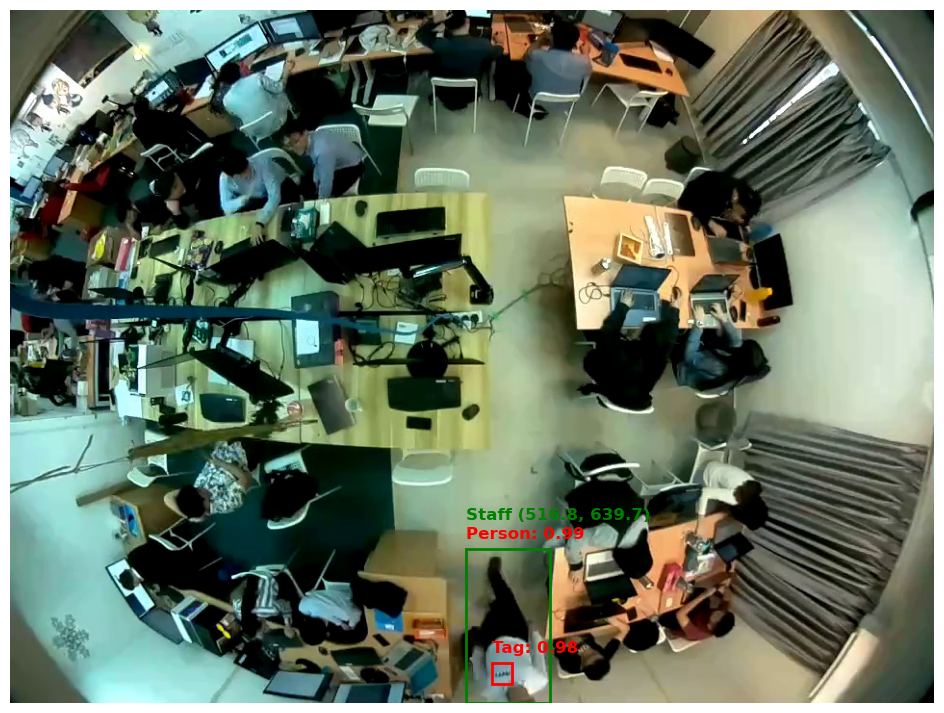

In [7]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\output4\frame.c_142.png"
predict_and_visualize(image_path)

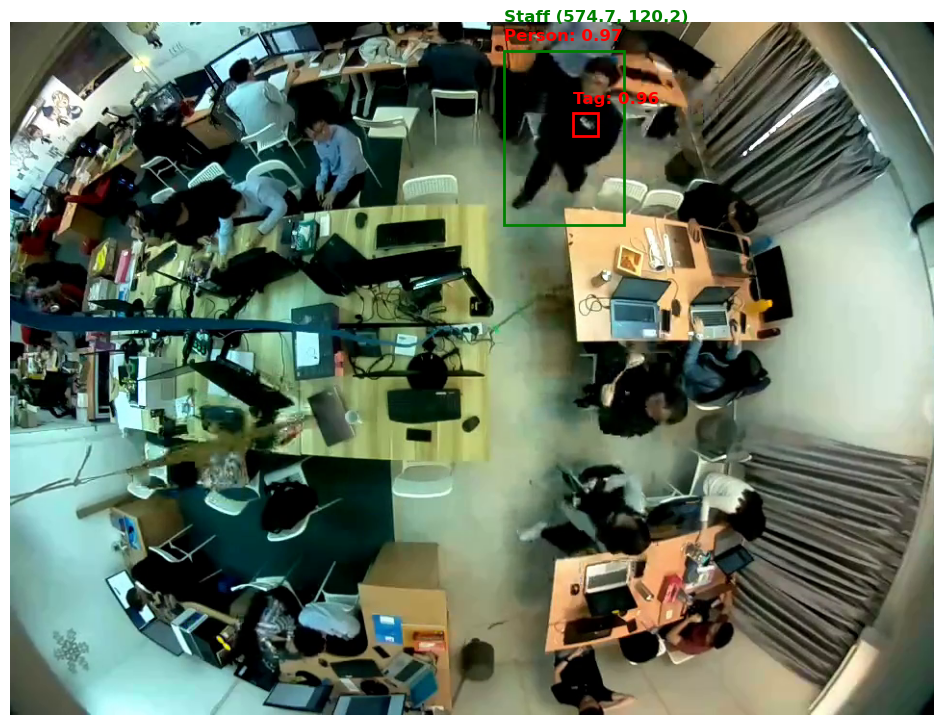

In [8]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\output4\frame.c_285.png"
predict_and_visualize(image_path)

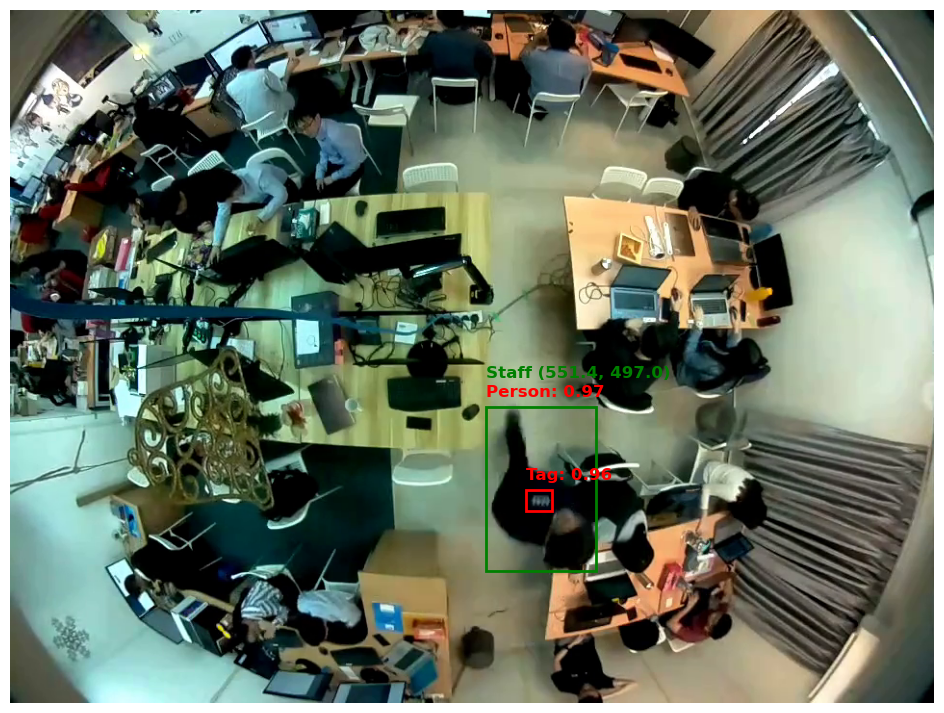

In [9]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\output4\frame.c_273.png"
predict_and_visualize(image_path)

The above tests shows that the model is capable of identifying the staff, now, I would like to test with other images <br>
Remarks for following test images:<br>
* test1: looks like the model can identify tag and staff nicely
* test2: model identify 'invisible' tag at back of person and did not find tag on cupboard
* test3: model identify 'invisible' tag at a person sleeve cuffs and did not find tag on cupboard
* test4: tag is identified when on person, person labeled as staff
* test5: tag is not identified when not on person
* test6: person sleeve cuffs does not get identified as tag when cropped out and place separately

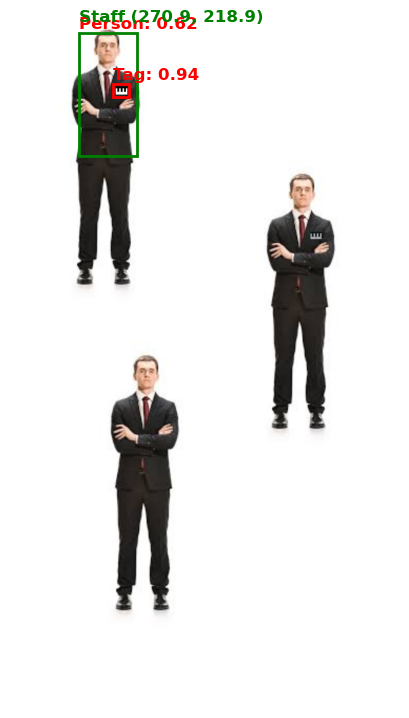

In [10]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\test\test1.png"
predict_and_visualize(image_path)

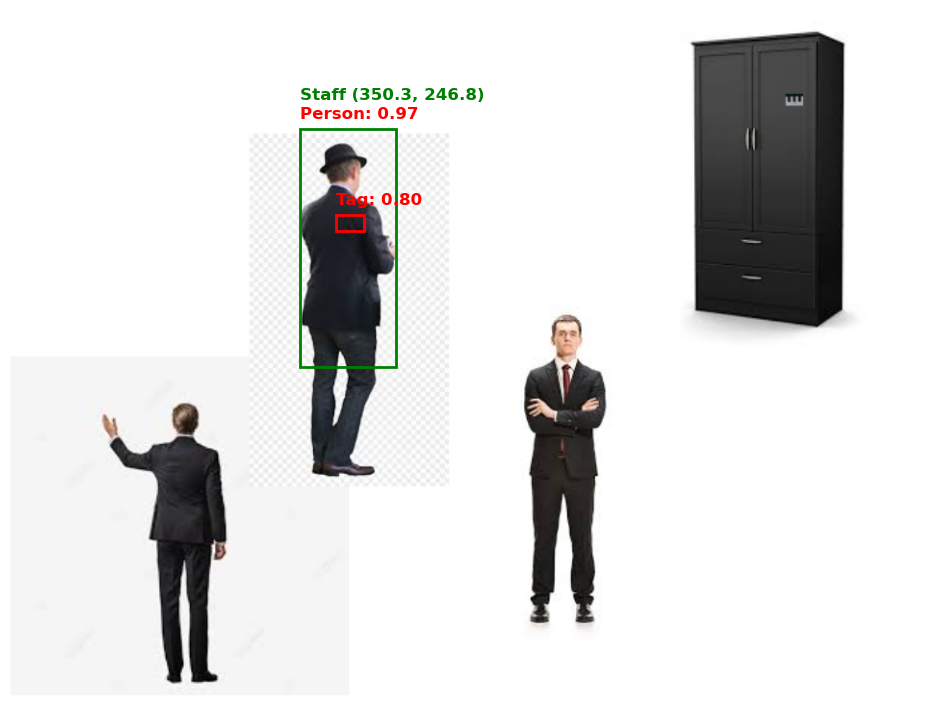

In [11]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\test\test2.png"
predict_and_visualize(image_path)

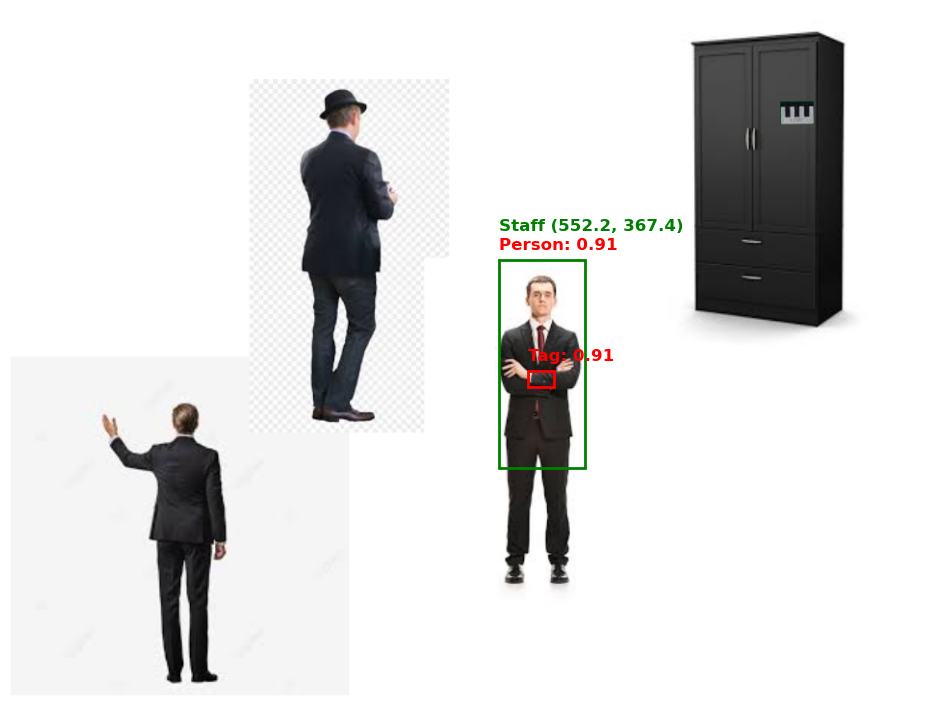

In [12]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\test\test3.png"
predict_and_visualize(image_path)

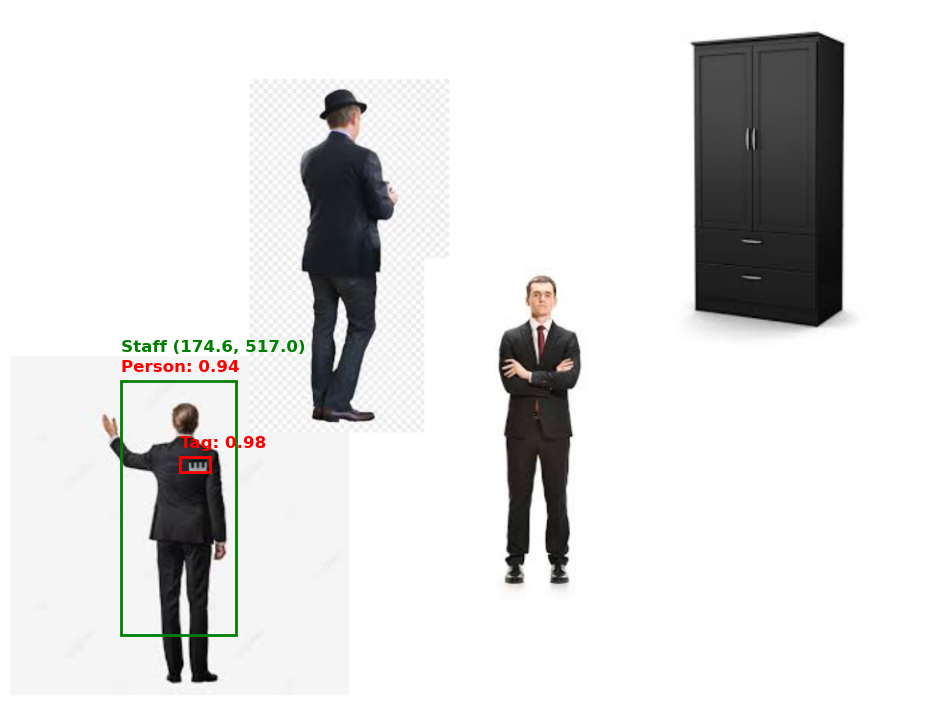

In [13]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\test\test4.png"
predict_and_visualize(image_path)

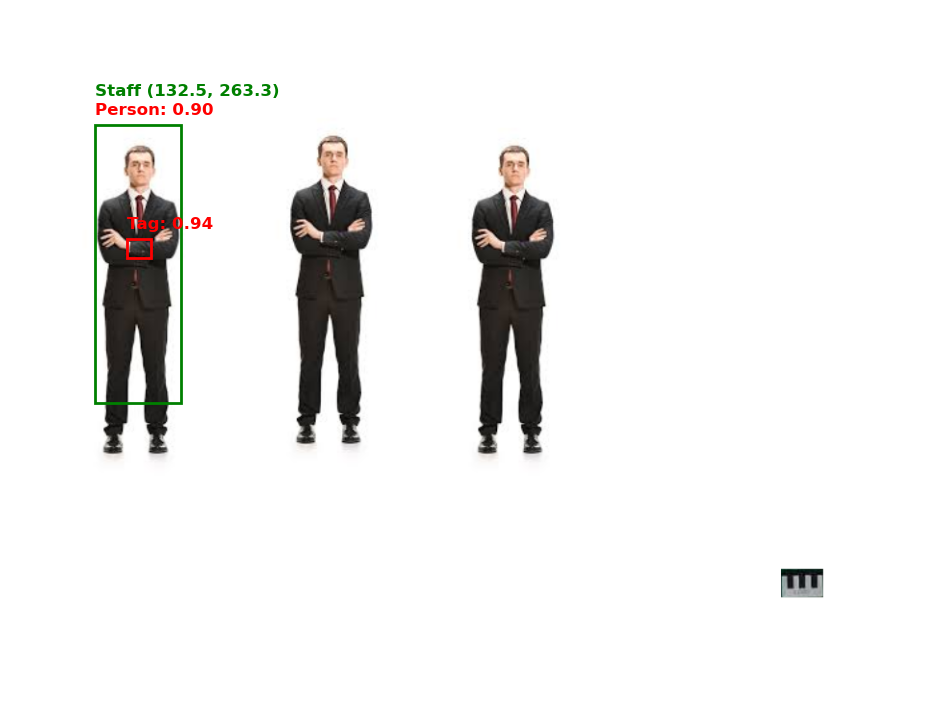

In [14]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\test\test5.png"
predict_and_visualize(image_path)

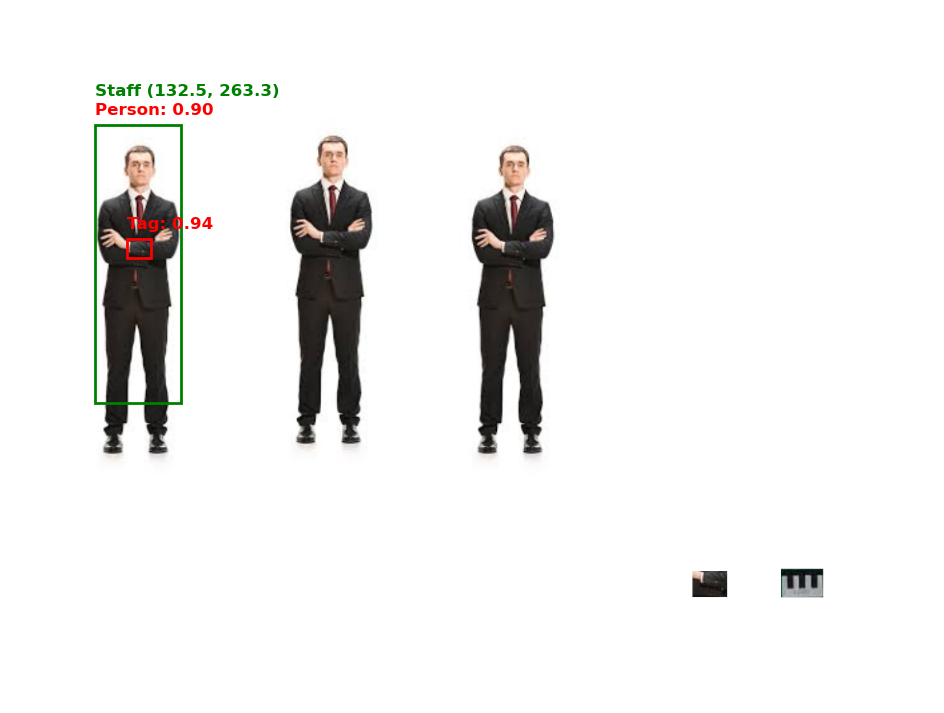

In [15]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\test\test6.png"
predict_and_visualize(image_path)

The following code draw all bounding box found when score is > confidence threshold (score > 0.5):
* person : blue color box
* tag: green color box

In [16]:
def predict_and_visualize_2(image_path, confidence_threshold=0.5):
    image_tensor, original_image = preprocess_image(image_path)
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']  # Assuming model outputs labels for each prediction
    
    # Plot the original image
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(original_image)

    # Iterate through bounding boxes, labels, and scores
    for box, score, label in zip(boxes, scores, labels):
        if score >= confidence_threshold:
            xmin, ymin, xmax, ymax = box
            
            # Set color based on label (assuming '1' is person, '2' is tag)
            if label == 1:  # Person
                color = 'blue'
                label_text = "Person"
            elif label == 2:  # Tag
                color = 'green'
                label_text = "Tag"
            else:
                continue  # Skip if the label is neither person nor tag
            
            # Draw the bounding box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            
            # Label the box with confidence score and class
            ax.text(
                xmin, ymin - 10, f"{label_text}: {score:.2f}",
                color=color, fontsize=12, weight='bold'
            )
    
    plt.axis("off")
    plt.show()

As shown in following image:
* person are successfully identified
* tag are detected on upper part of person's body although they are not there <br>

**Possible reason and solution:**
* Reason: Tag images used for training are blurry
* Solution: Use synthesised images with clear images of tag pasted on the tag which looks blur for training

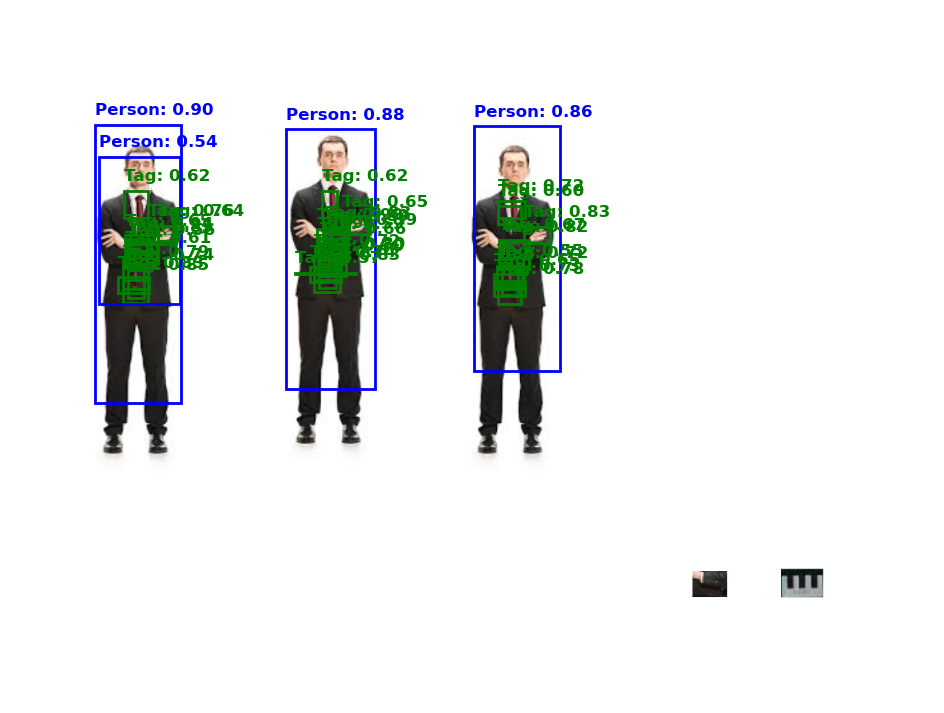

In [17]:
# Test with an image
image_path = r"C:\Users\ruyit\Pictures\test\test6.png"
predict_and_visualize_2(image_path)

## Output video

The following code are used to process the "sample.mp4" and output video with bounding box (Same steps as image processing above)

In [18]:
# Define the transformation for input image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
]) 

In [19]:
# Function to perform inference on a single image
def get_predictions(image, model, device):
    model.eval()  # Set model to evaluation mode
    image = image[0].to(device)  # Move the tensor inside the list to the device (GPU/CPU)
    
    with torch.no_grad():  # No need to track gradients during inference
        prediction = model([image])
    return prediction

In [20]:
# Open the video file
video_path = r"C:\Users\ruyit\Desktop\Play (Python)\Object detection (person + tag = staff)\sample.mp4"  # Change this to your video file
cap = cv2.VideoCapture(video_path)

# Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Prepare for saving output video
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Loop through video frames
while True:
    ret, frame = cap.read()
    
    if not ret:
        break  # End of video

    # Convert the frame to PIL image and apply transformations
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    # Get predictions
    predictions = get_predictions(image_tensor, model, device='cuda' if torch.cuda.is_available() else 'cpu')

    # Get the highest prediction scores for tag and person
    tag_boxes = []
    person_boxes = []
    tag_scores = []
    person_scores = []

    for element in range(len(predictions[0]['boxes'])):
        box = predictions[0]['boxes'][element].cpu().numpy()
        label = predictions[0]['labels'][element].cpu().numpy()
        score = predictions[0]['scores'][element].cpu().numpy()

        if score > 0.5:  # Threshold for score
            if label == 2:  # 'tag' class
                tag_boxes.append(box)
                tag_scores.append(score)
            elif label == 1:  # 'person' class
                person_boxes.append(box)
                person_scores.append(score)

    selected_person_box = None  # Initialize selected person box

    # If tag boxes are found, process the highest score tag
    if tag_boxes:
        max_tag_score_idx = tag_scores.index(max(tag_scores))  # Index of the highest score tag
        max_tag_box = tag_boxes[max_tag_score_idx]  # Box coordinates for the highest score tag
        x1, y1, x2, y2 = max_tag_box
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)  # Draw tag box
        cv2.putText(frame, f'Tag: {max(tag_scores):.2f}', (int(x1), int(y1)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

         # Now check if any person is detected within the area of the tag's bounding box
        for person_box, person_score in zip(person_boxes, person_scores):
            px1, py1, px2, py2 = person_box

            # Check if the person box is within or near the tag box (adjust this condition)
            if (px1 <= x1 and py1 <= y1) and (px2 >= x2 and py2 >= y2):
                selected_person_box = person_box  # Set this box as the selected person box
                selected_person_score = person_score  # Get the score for this person
                break  # Stop searching as we've found the first valid person box

        if selected_person_box is not None:  # If a person box is selected near the tag
            px1, py1, px2, py2 = selected_person_box
            midpoint_x = (px1 + px2) / 2
            midpoint_y = (py1 + py2) / 2

            cv2.rectangle(frame, (int(px1), int(py1)), (int(px2), int(py2)), (0, 255, 0), 2)  # Draw person box (Staff)
            cv2.putText(frame, f"Person: {person_score:.2f}", 
                        (int(px1), int(py1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.putText(frame, f"Staff ({midpoint_x:.1f}, {midpoint_y:.1f})", 
                        (int(px1), int(py1)-30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # If no tag is detected, select the person with the highest score
    elif person_boxes:
        max_person_score_idx = person_scores.index(max(person_scores))  # Index of the highest score person
        max_person_box = person_boxes[max_person_score_idx]  # Box coordinates for the highest score person
        px1, py1, px2, py2 = max_person_box
        cv2.rectangle(frame, (int(px1), int(py1)), (int(px2), int(py2)), (0, 0, 255), 2)  # Draw person box
        cv2.putText(frame, f"Person: {person_scores[max_person_score_idx]:.2f}", 
                    (int(px1), int(py1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Write the processed frame to the output video
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow("Video", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit the video display
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

## Conclusion

Overall, the model is successful on identifying the staff when tag is detected. <br>
Improvements can be made on:
* the accuracy of tag detection, by using synthesised image (same images for training, just replace blurry tag with synthesised tag image / cropped clear tag image)
* use object tracking to track staff when tag is not visible after staff is identified 